### Quora Data Challenge

In [88]:
import io
import numpy as np
import pandas as pd
import pandasql as ps
import plotly.tools as tls
import plotly.offline as py
import pandas_profiling as pp
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet

<Figure size 800x640 with 0 Axes>

Suppose you are a Data Scientist on the Mobile team at Quora.<br>The team has just introduced a new UI design to the Quora app.<br>The goal of the new design is to increase user engagement (measured by minutes spent on site). <br>The team ran an A/B test to evaluate the change.<br> Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

In [89]:
def build_dist(df,df1,col,col1,xlabelvalue,label1,label2):
    sns.distplot(df[col], hist=False, label = label1, axlabel = xlabelvalue)
    sns.distplot(df1[col1], hist=False, label = label2, axlabel = xlabelvalue)
    plt.show()

In [90]:
# reading the data sets
t1_user_active_min     = pd.read_csv("t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("t4_user_attributes.csv")
df_list = [t1_user_active_min,t2_user_variant,t3_user_active_min_pre,t4_user_attributes]

In [91]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [92]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [93]:
t2_user_variant['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

People in control group: 80 percent <br>
People in treatment group: 20 percent

In [94]:
user_control = []
user_treatment = []
for index,row in t2_user_variant.iterrows():
    if row['variant_number'] == 0:
        user_control.append(row['uid'])
    else:
        user_treatment.append(row['uid'])

In [95]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [96]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


### Hypothesis:
1. The AB Testing is intended to increase the user engagement in terms of time.
2. Randomized people are used to divide into control and treatment groups.

### KPI for AB Test to look for between treatment and control group:
1. Active time        - increased/ decreased
2. Frequency of visit - increased/decreased
3. Segregation of above two points for old/new users, male/female, reader/non-readers.
4. I will try to look for the combination of all the other factors

#### Creating Analytical Data Table for the user variant - combination of gender/reader/non-reader/days_since_signup

In [97]:
var_gen_ageinquora = pd.merge(t2_user_variant,t4_user_attributes,how = "inner", on = "uid")

In [98]:
var_gen_ageinquora.head()

,uid,variant_number,dt,signup_date,gender,user_type
0,0,0,2019-02-06,2018-09-24,male,non_reader
1,1,0,2019-02-06,2016-11-07,male,reader
2,2,0,2019-02-06,2018-09-17,male,non_reader
3,3,0,2019-02-06,2018-03-04,male,non_reader
4,4,0,2019-02-06,2017-03-09,male,non_reader


In [99]:
var_gen_ageinquora_control = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 0]
var_gen_ageinquora_treatment = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 1]
cat_cols = ['gender','user_type']
cont_cols = ['days_since_joined_till_AB_tested']

#### Checking the ratio in treatment and control group

In [100]:
treat_gender = pd.DataFrame(var_gen_ageinquora_treatment['gender'].value_counts())
treat_gender.rename(columns = {'gender':'count_treat_gender'}, inplace = True)
treat_gender.reset_index(inplace = True)
treat_gender.rename(columns = {'index':'gender'}, inplace = True)

In [101]:
control_gender = pd.DataFrame(var_gen_ageinquora_control['gender'].value_counts())
control_gender.rename(columns = {'gender':'count_control_gender'}, inplace = True)
control_gender.reset_index(inplace = True)
control_gender.rename(columns = {'index':'gender'}, inplace = True)

In [102]:
total_gender = pd.DataFrame(var_gen_ageinquora['gender'].value_counts())
total_gender.rename(columns = {'gender':'count_control_gender'}, inplace = True)
total_gender.reset_index(inplace = True)
total_gender.rename(columns = {'index':'gender'}, inplace = True)

In [103]:
treat_user_type = pd.DataFrame(var_gen_ageinquora_treatment['user_type'].value_counts())
treat_user_type.rename(columns = {'user_type':'count_treat_user_type'}, inplace = True)
treat_user_type.reset_index(inplace = True)
treat_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [104]:
control_user_type = pd.DataFrame(var_gen_ageinquora_control['user_type'].value_counts())
control_user_type.rename(columns = {'user_type':'count_control_user_type'}, inplace = True)
control_user_type.reset_index(inplace = True)
control_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [105]:
total_user_type = pd.DataFrame(var_gen_ageinquora['user_type'].value_counts())
total_user_type.rename(columns = {'user_type':'count_total_user_type'}, inplace = True)
total_user_type.reset_index(inplace = True)
total_user_type.rename(columns = {'index':'user_type'}, inplace = True)

In [106]:
gender_comparision = pd.merge(treat_gender, control_gender, on = "gender",how = "inner")
user_type_comparision = pd.merge(treat_user_type, control_user_type, on = "user_type",how = "inner")

In [107]:
gender_comparision['treat_ratio'] = gender_comparision['count_treat_gender'] / gender_comparision['count_treat_gender'].sum()
gender_comparision['control_ratio'] = gender_comparision['count_control_gender'] / gender_comparision['count_control_gender'].sum()

In [108]:
gender_comparision.drop(columns = ['count_treat_gender','count_control_gender'])

,gender,treat_ratio,control_ratio
0,male,0.552,0.555925
1,female,0.287,0.290175
2,unknown,0.161,0.153900


In [109]:
user_type_comparision['treat_ratio']   = user_type_comparision['count_treat_user_type'] / user_type_comparision['count_treat_user_type'].sum()
user_type_comparision['control_ratio'] = user_type_comparision['count_control_user_type'] / user_type_comparision['count_control_user_type'].sum()

In [110]:
user_type_comparision.drop(columns = ['count_treat_user_type','count_control_user_type'])

,user_type,treat_ratio,control_ratio
0,non_reader,0.7367,0.717475
1,reader,0.1269,0.168325
2,new_user,0.1235,0.091325
3,contributor,0.0129,0.022875


### After the test is conducted

In [111]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [112]:
uid_control         = list(var_gen_ageinquora_control["uid"])
uid_treatment       = list(var_gen_ageinquora_treatment["uid"])
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_control)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_treatment)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(uid_control)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(uid_treatment)]

In [113]:
# Validating if there is no common elements between control and treatment.
intersection(uid_control, uid_treatment)

[]

In [114]:
after_AB_control_uid    = list(after_AB_control['uid'])
after_AB_treatment_uid  = list(after_AB_treatment['uid'])
before_AB_control_uid   = list(before_AB_control['uid'])
before_AB_treatment_uid = list(before_AB_treatment['uid'])

In [115]:
common_control_uid   = intersection(after_AB_control_uid, before_AB_control_uid)
common_treatment_uid = intersection(after_AB_treatment_uid, before_AB_treatment_uid)

In [116]:
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_control_uid)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_treatment_uid)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(common_control_uid)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(common_treatment_uid)]

In [117]:
before_AB_control.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [118]:
before_AB_control_base_table   = pd.merge(before_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
before_AB_treatment_base_table = pd.merge(before_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_control_base_table    = pd.merge(after_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_treatment_base_table  = pd.merge(after_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")

In [119]:
before_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


#### Active minute comparision

In [120]:
# import seaborn as sns
# import plotly.express as px
# fig = px.histogram(before_AB_treatment_base_table_noout, x="active_mins")
# fig.show()

In [121]:
pd.DataFrame(before_AB_control_base_table['active_mins'].describe())

,active_mins
count,978727.00000
mean,35.77256
std,1283.01916
min,1.00000
25%,2.00000
50%,5.00000
75%,15.00000
max,99999.00000


In [122]:
pd.DataFrame(before_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,197942.000000
mean,16.222444
std,503.548367
min,1.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,99999.000000


In [123]:
pd.DataFrame(after_AB_control_base_table['active_mins'].describe())

,active_mins
count,886469.000000
mean,35.361478
std,1266.081303
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,99999.000000


In [124]:
pd.DataFrame(after_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,179291.000000
mean,40.270471
std,1294.258138
min,1.000000
25%,3.000000
50%,7.000000
75%,19.000000
max,99999.000000


In [125]:
after_AB_treatment_base_table.sort_values(by = ['active_mins'], ascending=False)[:5]

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
38650,42198,2019-06-08,99999.0,1,2019-02-06,2016-10-11,male,reader
141896,47957,2019-03-03,99999.0,1,2019-02-06,2013-07-05,male,reader
170027,49503,2019-03-10,99999.0,1,2019-02-06,2017-05-26,male,contributor
125504,47041,2019-04-06,99999.0,1,2019-02-06,2018-12-06,female,reader
170104,49503,2019-06-29,99999.0,1,2019-02-06,2017-05-26,male,contributor


In [126]:
before_AB_treatment_base_table_noout = before_AB_treatment_base_table[before_AB_treatment_base_table.active_mins < np.percentile(before_AB_treatment_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

In [127]:
before_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


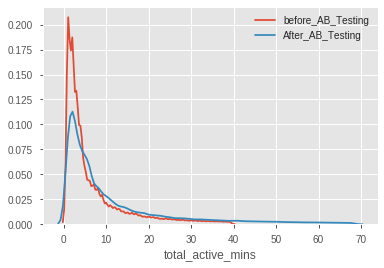

In [128]:
build_dist(before_AB_treatment_base_table_noout,after_AB_treatment_base_table_noout,
           "active_mins","active_mins","total_active_mins", "before_AB_Testing","After_AB_Testing")

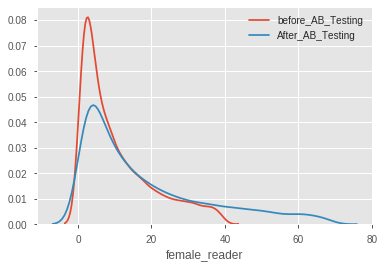

In [129]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","female_reader", "before_AB_Testing","After_AB_Testing")


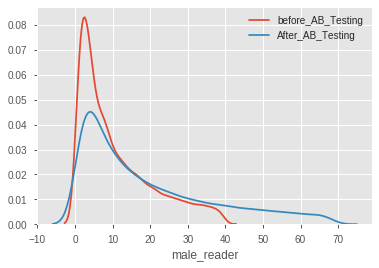

In [130]:


build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","male_reader", "before_AB_Testing","After_AB_Testing")


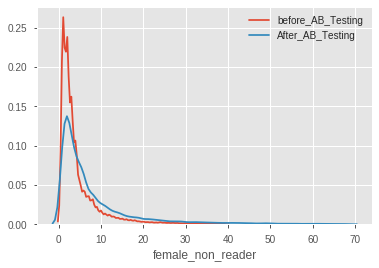

In [131]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins","female_non_reader", "before_AB_Testing","After_AB_Testing")


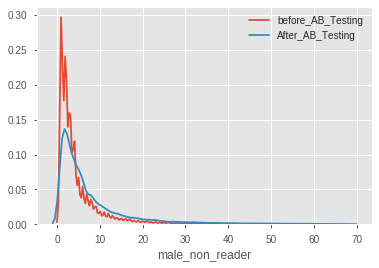

In [132]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins", "male_non_reader", "before_AB_Testing","After_AB_Testing")


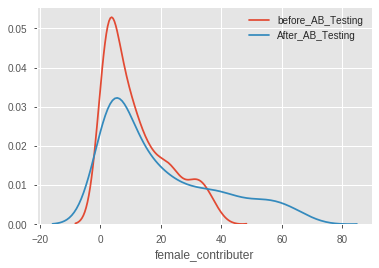

In [133]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","female_contributer", "before_AB_Testing","After_AB_Testing")

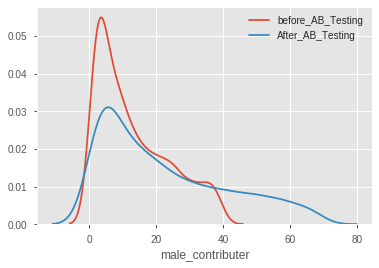

In [134]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","male_contributer", "before_AB_Testing","After_AB_Testing")


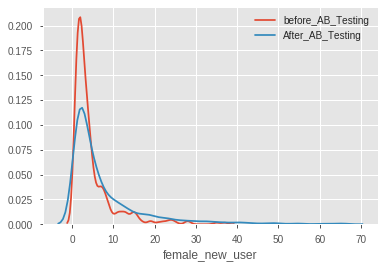

In [135]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","female_new_user", "before_AB_Testing","After_AB_Testing")

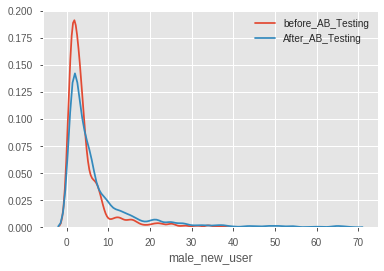

In [136]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","male_new_user", "before_AB_Testing","After_AB_Testing")

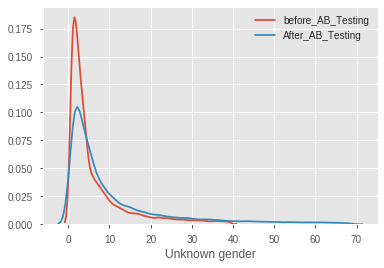

In [137]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")],
           "active_mins","active_mins","Unknown gender", "before_AB_Testing","After_AB_Testing")

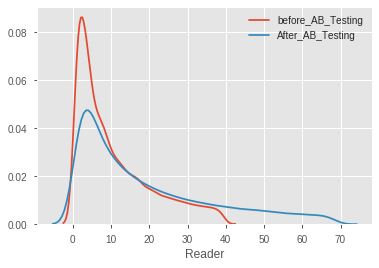

In [138]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "reader"],
           "active_mins","active_mins","Reader", "before_AB_Testing","After_AB_Testing")

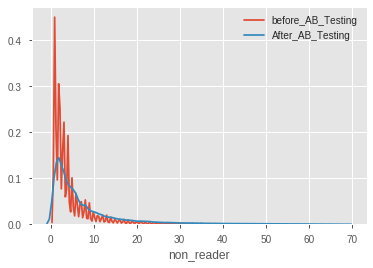

In [139]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           "active_mins","active_mins","non_reader", "before_AB_Testing","After_AB_Testing")

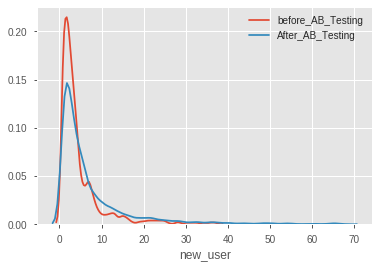

In [140]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "new_user"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "new_user"],
           "active_mins","active_mins","new_user", "before_AB_Testing","After_AB_Testing")

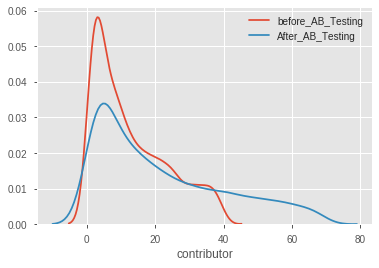

In [141]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "contributor"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "contributor"],
           "active_mins","active_mins","contributor", "before_AB_Testing","After_AB_Testing")

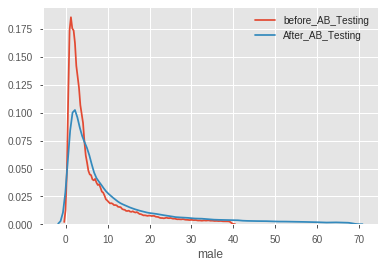

In [142]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "male"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "male"],
           "active_mins","active_mins","male", "before_AB_Testing","After_AB_Testing")

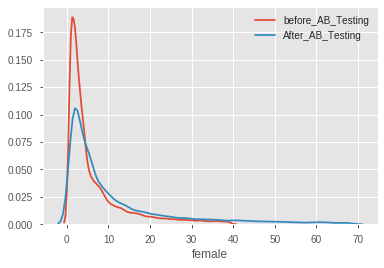

In [143]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "female"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "female"],
           "active_mins","active_mins","female", "before_AB_Testing","After_AB_Testing")

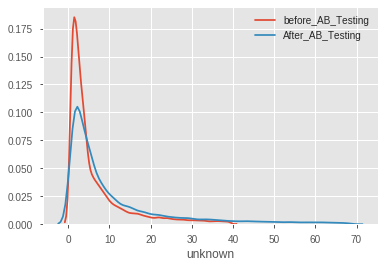

In [144]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "unknown"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "unknown"],
           "active_mins","active_mins","unknown", "before_AB_Testing","After_AB_Testing")

#### Trying to see the change in number of visits over the entire data

In [145]:
# Changing to date data-type
before_AB_treatment_base_table_noout['AB_Date'] = pd.to_datetime(before_AB_treatment_base_table_noout['AB_Date'])
before_AB_treatment_base_table_noout['signup_date'] = pd.to_datetime(before_AB_treatment_base_table_noout['signup_date'])
before_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


In [146]:
user_count_before_AB = pd.DataFrame(before_AB_treatment_base_table_noout['uid'].value_counts())
user_count_before_AB.reset_index(inplace = True)
user_count_before_AB.rename(columns = {'uid':'before_count', 'index':'uid'}, inplace = True)
user_count_after_AB = pd.DataFrame(after_AB_treatment_base_table_noout['uid'].value_counts())
user_count_after_AB.reset_index(inplace = True)
user_count_after_AB.rename(columns = {'uid':'after_count', 'index':'uid'}, inplace = True)

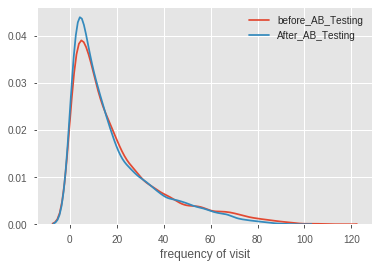

In [147]:
build_dist(user_count_before_AB,user_count_after_AB,'before_count','after_count','frequency of visit', "before_AB_Testing","After_AB_Testing")

In [148]:
frequency_AB_effect = pd.merge(user_count_before_AB, user_count_after_AB, how = "inner", on = "uid")
sample_df = pd.DataFrame(after_AB_treatment_base_table_noout.groupby(['uid'])[['gender','user_type']].min())

frequency_AB_effect = pd.merge(frequency_AB_effect, sample_df, how = "left", on = "uid")
visit_increased_0_1 = []
attribute_visit_increased = []
attribute_visit_decreased = []
for index,row in frequency_AB_effect.iterrows():
    if row['after_count'] > row['before_count']:
        visit_increased_0_1.append(1)
        attribute_visit_increased.append([row['gender'],row['user_type']])
    else:
        visit_increased_0_1.append(0)
        attribute_visit_decreased.append([row['gender'],row['user_type']])
        
        
a = pd.DataFrame(attribute_visit_increased)
b = pd.DataFrame(attribute_visit_decreased)


analysis_increased_gender = pd.DataFrame(a[0].value_counts())
analysis_increased_gender.reset_index(inplace = True)

analysis_increased_gender.rename(columns = {0:'increased_after_AB_Testing', 'index':'gender'}, inplace = True)

analysis_increased_user_type= pd.DataFrame(a[1].value_counts())
analysis_increased_user_type.reset_index(inplace = True)

analysis_increased_user_type.rename(columns = {1:'increased_after_AB_Testing', 'index':'user_type'}, inplace = True)

analysis_decreased_gender = pd.DataFrame(b[0].value_counts())
analysis_decreased_gender.reset_index(inplace = True)

analysis_decreased_gender.rename(columns = {0:'decreased_after_AB_Testing', 'index':'gender'}, inplace = True)

analysis_decreased_user_type= pd.DataFrame(b[1].value_counts())
analysis_decreased_user_type.reset_index(inplace = True)
analysis_decreased_user_type.rename(columns = {1:'decreased_after_AB_Testing', 'index':'user_type'}, inplace = True)

analysis_gender_AB = pd.merge(analysis_increased_gender, analysis_decreased_gender,
                             how = "inner", on = "gender")

analysis_usertype_AB = pd.merge(analysis_increased_user_type, analysis_decreased_user_type,
                             how = "inner", on = "user_type")

In [149]:
analysis_usertype_AB.head()

,user_type,increased_after_AB_Testing,decreased_after_AB_Testing
0,non_reader,2554,4451
1,new_user,546,223
2,reader,455,804
3,contributor,49,77


In [150]:
analysis_gender_AB.head()

,gender,increased_after_AB_Testing,decreased_after_AB_Testing
0,male,1995,3127
1,female,1044,1545
2,unknown,565,883


#### Trying to see the change in amount of time spent over the entire data

In [151]:
before_AB = pd.DataFrame(before_AB_treatment_base_table_noout.groupby(['uid'])['active_mins'].sum())
after_AB = pd.DataFrame(after_AB_treatment_base_table_noout.groupby(['uid'])['active_mins'].sum())
after_AB.reset_index(inplace = True)
after_AB.rename(columns = {'active_mins':'total_active_time_after_AB_testing'}, inplace = True)
before_AB.reset_index(inplace = True)
before_AB.rename(columns = {'active_mins':'total_active_time_before_AB_testing'}, inplace = True)

active_min_AB_testing_analysis = pd.merge(before_AB,after_AB, on = "uid", how = "inner")
active_min_AB_testing_analysis = pd.merge(active_min_AB_testing_analysis,
                                          t4_user_attributes, how = 'left', on = "uid")

visit_increased_0_1 = []
attribute_visit_increased = []
attribute_visit_decreased = []
for index,row in active_min_AB_testing_analysis.iterrows():
    if row['total_active_time_after_AB_testing'] > row['total_active_time_before_AB_testing']:
        visit_increased_0_1.append(1)
        attribute_visit_increased.append([row['gender'],row['user_type']])
    else:
        visit_increased_0_1.append(0)
        attribute_visit_decreased.append([row['gender'],row['user_type']])
        
        
a = pd.DataFrame(attribute_visit_increased)
b = pd.DataFrame(attribute_visit_decreased)


time_increased_gender = pd.DataFrame(a[0].value_counts())
time_increased_gender.reset_index(inplace = True)

time_increased_gender.rename(columns = {0:'increased_after_AB_Testing', 'index':'gender'}, inplace = True)

time_increased_user_type= pd.DataFrame(a[1].value_counts())
time_increased_user_type.reset_index(inplace = True)

time_increased_user_type.rename(columns = {1:'increased_after_AB_Testing', 'index':'user_type'}, inplace = True)

time_decreased_gender = pd.DataFrame(b[0].value_counts())
time_decreased_gender.reset_index(inplace = True)

time_decreased_gender.rename(columns = {0:'decreased_after_AB_Testing', 'index':'gender'}, inplace = True)

time_decreased_user_type= pd.DataFrame(b[1].value_counts())
time_decreased_user_type.reset_index(inplace = True)
time_decreased_user_type.rename(columns = {1:'decreased_after_AB_Testing', 'index':'user_type'}, inplace = True)

time_analysis_gender_AB = pd.merge(analysis_increased_gender, analysis_decreased_gender,
                             how = "inner", on = "gender")

time_analysis_usertype_AB = pd.merge(analysis_increased_user_type, analysis_decreased_user_type,
                             how = "inner", on = "user_type")

In [152]:
time_analysis_gender_AB.head()

,gender,increased_after_AB_Testing,decreased_after_AB_Testing
0,male,1995,3127
1,female,1044,1545
2,unknown,565,883


In [153]:
time_analysis_usertype_AB.head()

,user_type,increased_after_AB_Testing,decreased_after_AB_Testing
0,non_reader,2554,4451
1,new_user,546,223
2,reader,455,804
3,contributor,49,77


#### Between control and treatment group 

In [154]:
after_AB_control_base_table_noout = after_AB_control_base_table[after_AB_control_base_table.active_mins < np.percentile(after_AB_control_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

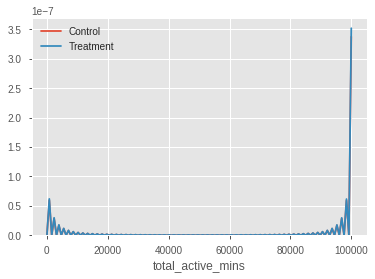

In [155]:
build_dist(after_AB_control_base_table,after_AB_treatment_base_table,
           "active_mins","active_mins","total_active_mins","Control","Treatment")

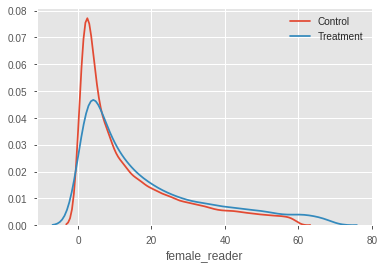

In [156]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","female_reader","Control","Treatment")

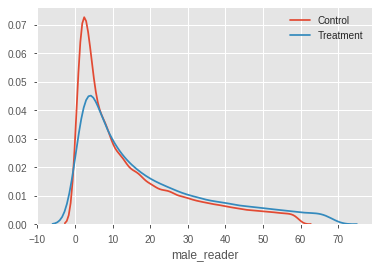

In [157]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","male_reader", "Control", "Treatment")

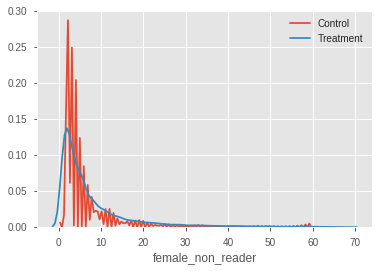

In [158]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins","female_non_reader", "Control", "Treatment")

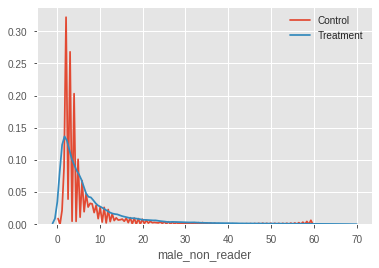

In [159]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins", "male_non_reader", "Control", "Treatment")

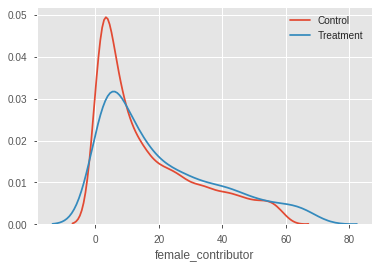

In [160]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","female_contributor", "Control", "Treatment")

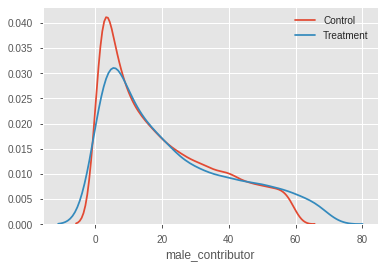

In [161]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","male_contributor", "Control", "Treatment")

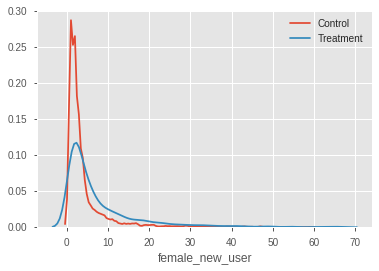

In [162]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","female_new_user", "Control", "Treatment")

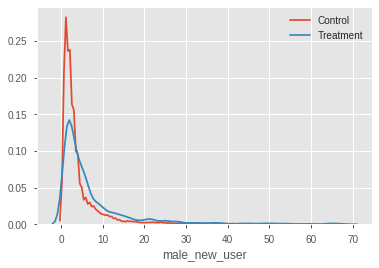

In [163]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","male_new_user", "Control", "Treatment")

#### Regrression and p-value analysis

In [164]:
before_AB_treatment_base_table['date'] = pd.to_datetime(before_AB_treatment_base_table['date'])
before_AB_treatment_base_table['AB_Date'] = pd.to_datetime(before_AB_treatment_base_table['AB_Date'])
before_AB_treatment_base_table['signup_date'] = pd.to_datetime(before_AB_treatment_base_table['signup_date'])

after_AB_control_base_table['date'] = pd.to_datetime(after_AB_control_base_table['date'])
after_AB_control_base_table['AB_Date'] = pd.to_datetime(after_AB_control_base_table['AB_Date'])
after_AB_control_base_table['signup_date'] = pd.to_datetime(after_AB_control_base_table['signup_date'])

after_AB_treatment_base_table['date'] = pd.to_datetime(after_AB_treatment_base_table['date'])
after_AB_treatment_base_table['AB_Date'] = pd.to_datetime(after_AB_treatment_base_table['AB_Date'])
after_AB_treatment_base_table['signup_date'] = pd.to_datetime(after_AB_treatment_base_table['signup_date'])

before_AB_control_base_table['date'] = pd.to_datetime(before_AB_control_base_table['date'])
before_AB_control_base_table['AB_Date'] = pd.to_datetime(before_AB_control_base_table['AB_Date'])
before_AB_control_base_table['signup_date'] = pd.to_datetime(before_AB_control_base_table['signup_date'])


In [165]:
before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['AB_Date'] - before_AB_control_base_table['signup_date']
before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['days_since_signup'].apply(lambda x:x.days)

after_AB_control_base_table['days_since_signup'] = after_AB_control_base_table['AB_Date'] - after_AB_control_base_table['signup_date']
after_AB_control_base_table['days_since_signup'] = after_AB_control_base_table['days_since_signup'].apply(lambda x:x.days)

after_AB_treatment_base_table['days_since_signup'] = after_AB_treatment_base_table['AB_Date'] - after_AB_treatment_base_table['signup_date']
after_AB_treatment_base_table['days_since_signup'] = after_AB_treatment_base_table['days_since_signup'].apply(lambda x:x.days)

before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['AB_Date'] - before_AB_control_base_table['signup_date']
before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['days_since_signup'].apply(lambda x:x.days)

In [166]:
after_AB_treatment_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type,days_since_signup
0,40001,2019-02-14,16.0,1,2019-02-06,2017-04-29,male,non_reader,648
1,40001,2019-02-17,5.0,1,2019-02-06,2017-04-29,male,non_reader,648
2,40001,2019-02-22,16.0,1,2019-02-06,2017-04-29,male,non_reader,648
3,40001,2019-02-24,5.0,1,2019-02-06,2017-04-29,male,non_reader,648
4,40001,2019-02-25,34.0,1,2019-02-06,2017-04-29,male,non_reader,648


In [167]:
col_to_drop = ['date','AB_Date','signup_date']

In [168]:
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type,days_since_signup
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader,135
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader,135
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader,135
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader,135
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader,135


In [169]:
dum_1 = pd.get_dummies(before_AB_control_base_table['gender'])
dum_2 = pd.get_dummies(before_AB_control_base_table['user_type'])
before_AB_control_base_table = pd.concat([before_AB_control_base_table,dum_1,dum_2], axis = 1)
before_AB_control_base_table.drop(columns = col_to_drop, inplace = True)
a = pd.DataFrame(before_AB_control_base_table['uid'].value_counts())
a.reset_index(inplace = True)
a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
before_AB_control_base_table = pd.merge(before_AB_control_base_table,a,how = "inner",
                                        on = "uid")
col_to_group_by = list(before_AB_control_base_table.columns)
col_to_group_by.remove('active_mins')
before_AB_control_base_table = pd.DataFrame(before_AB_control_base_table.groupby(col_to_group_by)['active_mins'].sum())
before_AB_control_base_table.reset_index(inplace = True)
before_AB_control_base_table.drop(columns = ['user_type','gender'], inplace = True)
before_AB_control_base_table['avg_time_per_user'] = before_AB_control_base_table['active_mins']/before_AB_control_base_table['appearences']
before_AB_control_base_table.to_csv("before_AB_control_base_table.csv", index = False)

dum_1 = pd.get_dummies(before_AB_treatment_base_table['gender'])
dum_2 = pd.get_dummies(before_AB_treatment_base_table['user_type'])
before_AB_treatment_base_table = pd.concat([before_AB_treatment_base_table,dum_1,dum_2], axis = 1)
before_AB_treatment_base_table.drop(columns = col_to_drop, inplace = True)
a = pd.DataFrame(before_AB_treatment_base_table['uid'].value_counts())
a.reset_index(inplace = True)
a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
before_AB_treatment_base_table = pd.merge(before_AB_treatment_base_table,a,how = "inner",
                                        on = "uid")
col_to_group_by = list(before_AB_treatment_base_table.columns)
col_to_group_by.remove('active_mins')
before_AB_treatment_base_table = pd.DataFrame(before_AB_treatment_base_table.groupby(col_to_group_by)['active_mins'].sum())
before_AB_treatment_base_table.reset_index(inplace = True)
before_AB_treatment_base_table.drop(columns = ['user_type','gender'], inplace = True)
before_AB_treatment_base_table['avg_time_per_user'] = before_AB_treatment_base_table['active_mins']/before_AB_treatment_base_table['appearences']
before_AB_treatment_base_table.to_csv("before_AB_treatment_base_table.csv", index = False)


dum_1 = pd.get_dummies(after_AB_control_base_table['gender'])
dum_2 = pd.get_dummies(after_AB_control_base_table['user_type'])
after_AB_control_base_table = pd.concat([after_AB_control_base_table,dum_1,dum_2], axis = 1)
after_AB_control_base_table.drop(columns = col_to_drop, inplace = True)
a = pd.DataFrame(after_AB_control_base_table['uid'].value_counts())
a.reset_index(inplace = True)
a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
after_AB_control_base_table = pd.merge(after_AB_control_base_table,a,how = "inner",
                                        on = "uid")
col_to_group_by = list(after_AB_control_base_table.columns)
col_to_group_by.remove('active_mins')
after_AB_control_base_table = pd.DataFrame(after_AB_control_base_table.groupby(col_to_group_by)['active_mins'].sum())
after_AB_control_base_table.reset_index(inplace = True)
after_AB_control_base_table.drop(columns = ['user_type','gender'], inplace = True)
after_AB_control_base_table['avg_time_per_user'] = after_AB_control_base_table['active_mins']/after_AB_control_base_table['appearences']
after_AB_control_base_table.to_csv("after_AB_control_base_table.csv", index = False)


dum_1 = pd.get_dummies(after_AB_treatment_base_table['gender'])
dum_2 = pd.get_dummies(after_AB_treatment_base_table['user_type'])
after_AB_treatment_base_table = pd.concat([after_AB_treatment_base_table,dum_1,dum_2], axis = 1)
after_AB_treatment_base_table.drop(columns = col_to_drop, inplace = True)
a = pd.DataFrame(after_AB_treatment_base_table['uid'].value_counts())
a.reset_index(inplace = True)
a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
after_AB_treatment_base_table = pd.merge(after_AB_treatment_base_table,a,how = "inner",
                                        on = "uid")
col_to_group_by = list(after_AB_treatment_base_table.columns)
col_to_group_by.remove('active_mins')
after_AB_treatment_base_table = pd.DataFrame(after_AB_treatment_base_table.groupby(col_to_group_by)['active_mins'].sum())
after_AB_treatment_base_table.reset_index(inplace = True)
after_AB_treatment_base_table.drop(columns = ['user_type','gender'], inplace = True)
after_AB_treatment_base_table['avg_time_per_user'] = after_AB_treatment_base_table['active_mins']/after_AB_treatment_base_table['appearences']
after_AB_treatment_base_table.to_csv("after_AB_treatment_base_table.csv", index = False)

In [170]:
after_AB_treatment_base_table.head()

,uid,variant_number,days_since_signup,female,male,unknown,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
0,40001,1,648,0,1,0,0,0,1,0,32,299.0,9.343750
1,40002,1,1264,0,1,0,0,0,1,0,26,183.0,7.038462
2,40004,1,1396,1,0,0,0,0,1,0,9,56.0,6.222222
3,40005,1,703,1,0,0,0,0,1,0,36,289.0,8.027778
4,40006,1,964,1,0,0,0,0,1,0,36,194.0,5.388889


In [171]:
X = before_AB_control_base_table[before_AB_control_base_table.columns.difference(['active_mins'])]
y = before_AB_control_base_table.loc[:,'active_mins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
p_value_dict = dict(model.pvalues)

# Print out the statistics
model.summary()

/home/sagnik/.local/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide

/home/sagnik/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/home/sagnik/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/home/sagnik/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/home/sagnik/.local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning:

divide by zero encountered in double_scalars



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            active_mins   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 1.434e+04
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:37:22   Log-Likelihood:            -3.0663e+05
No. Observations:               29850   AIC:                         6.133e+05
Df Residuals:                   29840   BIC:                         6.134e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
appearences          34.1479      2.051     16.647      0.000      30.127      38.168
avg_time_per_user    80.5530      0.229    351.027      0.000      80.103      81.003
contributor        -560.7797    248.627     -2.256      0.024   -1048.099     -73.461
days_since_signup    -0.0163      0.071     -0.229      0.819      -0.156       0.123
female             -618.3256     95.560     -6.471      0.000    -805.627    -431.024
male               -728.5999     90.397     -8.060      0.000    -905.781    -551.419
new_user            212.0498    154.544      1.372      0.170     -90.862     514.962
non_reader         -278.3836     73.062     -3.810      0.000    -421.587    -135.180
reader            -1412.6891    122.837    -11.501      0.000   -1653.454   -1171.924
uid                   0.0037      0.004      1.062      0.288      -0.003       0.011
unknown            -692.8770    114.120     -6.071      0.000    -916.557    -469.197
variant_number             0          0        nan        nan           0           0
==============================================================================
Omnibus:                    81921.769   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      36251693885.042
Skew:                         -33.377   Prob(JB):                         0.00
Kurtosis:                    5401.392   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Calculation of parameters for the r script

In [192]:
p1 = 0.86
p2 = 0.84
h = abs(2*np.arcsin(math.sqrt(p1))-2*np.arcsin(math.sqrt(p2)))
h
n1 = 9165
n2 = 37313
sig.level = 0.05
power = 
alternative = two.sided

0.05603968427310946

#### For the t-test

In [196]:
after_AB_treatment_base_table['avg_time_per_user'].describe()

count    9165.000000
mean       15.635999
std       116.261957
min         1.000000
25%         3.866667
50%         6.000000
75%        10.700000
max      6044.261682
Name: avg_time_per_user, dtype: float64

In [195]:
after_AB_control_base_table['avg_time_per_user'].describe()

count    37313.000000
mean        13.257813
std        185.226048
min          1.000000
25%          2.464286
50%          3.711111
75%          6.947368
max      16025.471429
Name: avg_time_per_user, dtype: float64

sd for the t test

In [198]:
sd = np.sqrt((116.261957**2 + 185.226048**2)/2)
sd

154.63753021690457